In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
import sys
sys.path.append("../dnn_from_scratch")

In [3]:
from matplotlib.image import imread
import cv2

In [4]:
DATA_DIR="/home/archer/machine_learning/Celeb100k/100k"
with open(DATA_DIR+".txt","r") as f:
    names=f.read().split('\n')[:-1]

In [5]:
def get_batch(st,btsz):
    X_train=[]
    for ii in names[st:st+btsz]:
        img=imread(DATA_DIR+"/"+ii)
        img=cv2.resize(img, dsize=(64,64))#, interpolation=cv2.INTER_CUBIC)
        X_train.append(img/255*2-1)
    return np.asarray(X_train)

In [6]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 291
Seed: 47


In [7]:
def generator():
    model=Sequential()
    model.add(dense(512*8*8,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((8,8,512)))
#     model.add(upsampling())
#     model.add(conv2d(256,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(256,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(upsampling())
#     model.add(conv2d(128,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(128,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(upsampling())
#     model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(upsampling())
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(conv2d(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 32768)              leakyRelu        3309568
__________________________________________________________________________________________
2 reshape(reshape)        (None, 8, 8, 512)          echo             0
__________________________________________________________________________________________
3 upsampling(upsampling)  (None, 16, 16, 512)        echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 16, 16, 256)        leakyRelu        1179904
__________________________________________________________________________________________
5 Ba

In [8]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu,input_shape=(64,64,3)))
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(max_pool())
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(max_pool())
    model.add(conv2d(128,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(max_pool())
    model.add(conv2d(256,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(dropout(0.2))
    model.add(max_pool())
    model.add(flatten())
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 64, 64, 3)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 64, 64, 32)         leakyRelu        896
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 64, 64, 32)         echo             128
__________________________________________________________________________________________
3 max_pool(max_pool)      (None, 32, 32, 32)         echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 32, 32, 64)         leakyRelu        18496
__________________________________________________________________________________________
5 BatchN

In [9]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [ ]:
noise=np.random.randn(32,100).astype(np.float32)
gen=g.predict(noise)

In [10]:
def gen_sample():
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])

In [11]:
ccu=0

In [20]:
def run():
    global ccu
    batch_size=32
    dsz=len(names)
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=get_batch(ccu,batch_size)
        ccu+=batch_size
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
#         y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
#         y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%10:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,time()-stt),end='')

EPOCH: 1 / 10


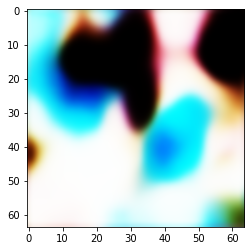

[0.10047702]
Progress: 0.29 %     Dloss: 24.808998107910156    Sample time: 5.713s    _

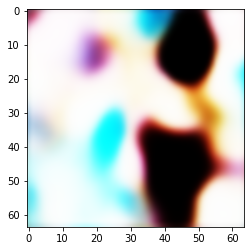

[0.5006346]
Progress: 0.61 %     Dloss: 24.833303451538086    Sample time: 5.767s    _

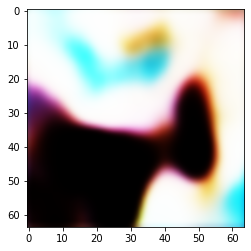

[0.38331452]
Progress: 0.93 %     Dloss: 25.314517974853516    Sample time: 5.710s    _

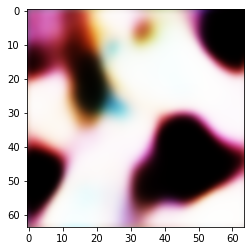

[0.4374128]
Progress: 1.25 %     Dloss: 24.60829734802246    Sample time: 5.772s    __

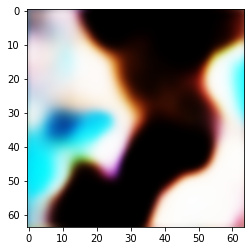

[0.58902884]
Progress: 1.57 %     Dloss: 25.64598274230957    Sample time: 5.700s    __

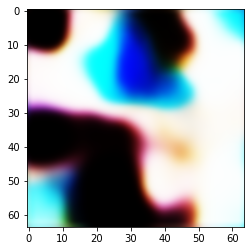

[0.26197898]
Progress: 1.89 %     Dloss: 24.741859436035156    Sample time: 5.780s    _

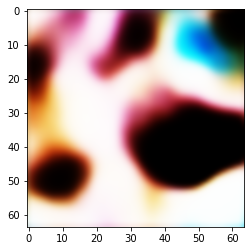

[0.62315804]
Progress: 2.21 %     Dloss: 24.62744140625    Sample time: 5.679s    _   _

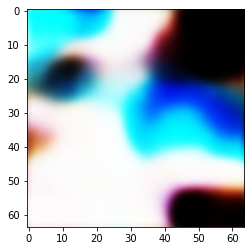

[0.4837943]
Progress: 2.53 %     Dloss: 24.76696014404297    Sample time: 5.798s    __

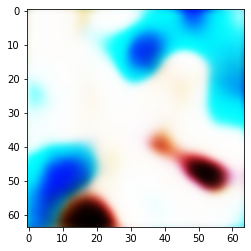

[0.9639399]
Progress: 2.85 %     Dloss: 24.812240600585938    Sample time: 5.673s    _

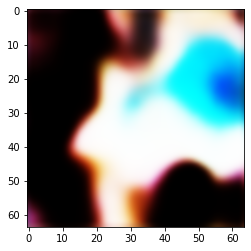

[0.56886166]
Progress: 3.17 %     Dloss: 24.590335845947266    Sample time: 5.930s    _

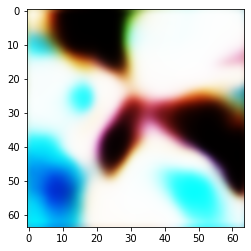

[0.65113306]
Progress: 3.49 %     Dloss: 22.844282150268555    Sample time: 5.736s    _

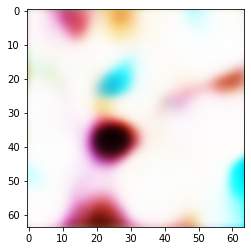

[0.7567875]
Progress: 3.81 %     Dloss: 23.470218658447266    Sample time: 5.960s    _

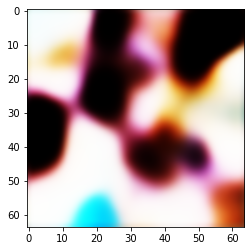

[0.36650074]
Progress: 4.13 %     Dloss: 23.144386291503906    Sample time: 5.704s    _

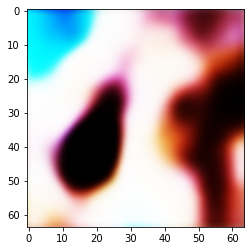

[0.40682888]
Progress: 4.45 %     Dloss: 23.14200210571289    Sample time: 6.013s    __

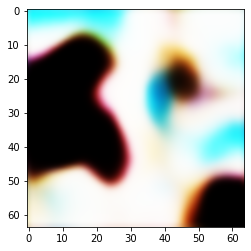

[0.3657299]
Progress: 4.77 %     Dloss: 23.316078186035156    Sample time: 5.732s    _

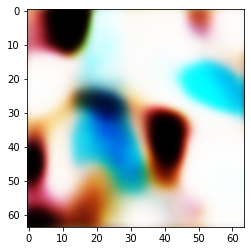

[0.7783682]
Progress: 5.09 %     Dloss: 23.299137115478516    Sample time: 5.873s    _

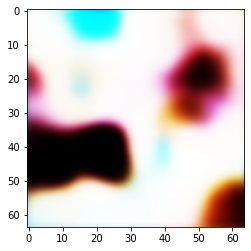

[0.42681986]
Progress: 5.41 %     Dloss: 22.977323532104492    Sample time: 5.675s    _

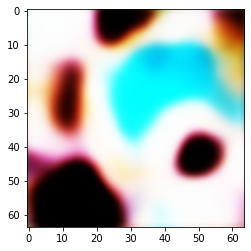

[0.33672616]
Progress: 5.73 %     Dloss: 22.899869918823242    Sample time: 5.922s    _

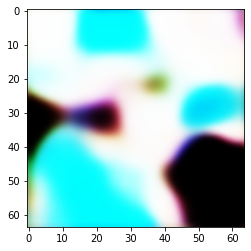

[0.48986015]
Progress: 6.05 %     Dloss: 23.383188247680664    Sample time: 5.704s    _

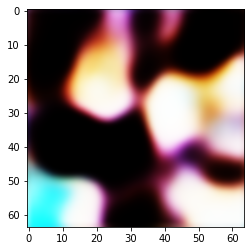

[0.45289704]
Progress: 6.37 %     Dloss: 22.780414581298828    Sample time: 5.916s    _

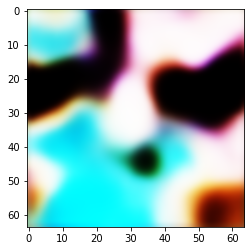

[0.7045549]
Progress: 6.69 %     Dloss: 22.7959041595459    Sample time: 5.742s    _ _

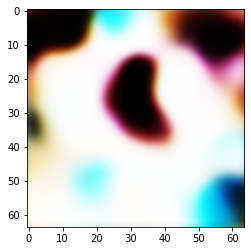

[0.56091565]
Progress: 7.01 %     Dloss: 22.802959442138672    Sample time: 5.986s    _

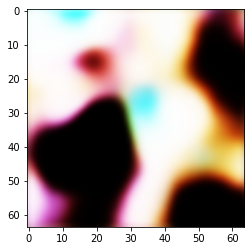

[0.3080803]
Progress: 7.33 %     Dloss: 23.026472091674805    Sample time: 5.677s    _

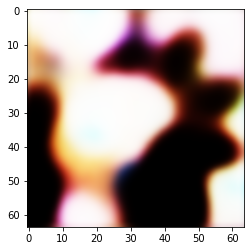

[0.66884804]
Progress: 7.65 %     Dloss: 22.5491943359375    Sample time: 5.950s    _ _

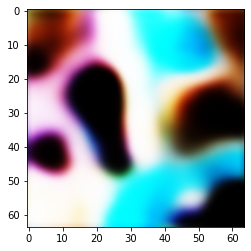

[0.6349976]
Progress: 7.97 %     Dloss: 22.9250431060791    Sample time: 5.667s    _ _

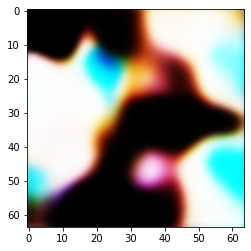

[0.4901893]
Progress: 8.29 %     Dloss: 22.633424758911133    Sample time: 5.856s    _

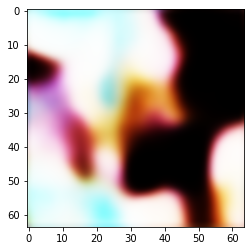

[0.45212236]
Progress: 8.61 %     Dloss: 22.751659393310547    Sample time: 5.664s    _

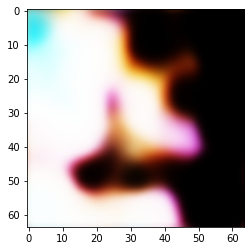

[0.56299365]
Progress: 8.93 %     Dloss: 22.915855407714844    Sample time: 5.895s    _

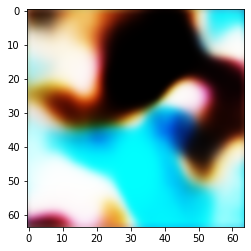

[0.7460101]
Progress: 9.25 %     Dloss: 22.96175193786621    Sample time: 5.683s    __

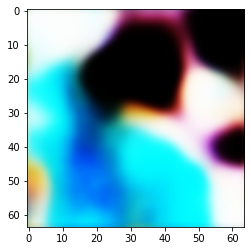

[0.042723]
Progress: 9.57 %     Dloss: 22.679943084716797    Sample time: 6.020s    _

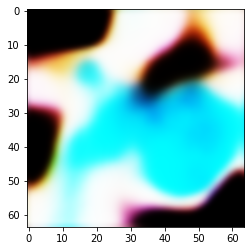

[0.47674507]
Progress: 9.89 %     Dloss: 22.502971649169922    Sample time: 5.710s    _

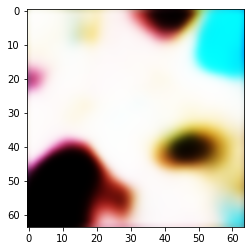

[0.3974225]
Progress: 10.21 %     Dloss: 22.694923400878906    Sample time: 5.658s    _

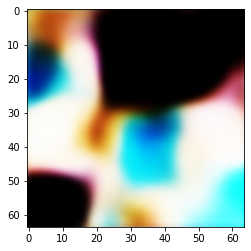

[0.53782237]
Progress: 10.53 %     Dloss: 22.62118148803711    Sample time: 5.680s    __

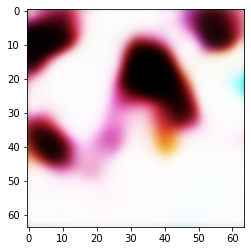

[0.4931492]
Progress: 10.85 %     Dloss: 23.122648239135742    Sample time: 5.729s    _

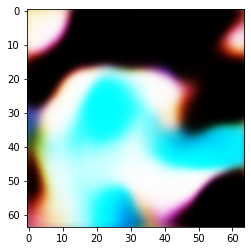

[0.6245999]
Progress: 11.17 %     Dloss: 22.650535583496094    Sample time: 5.671s    _

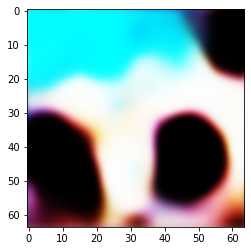

[0.35542125]
Progress: 11.49 %     Dloss: 22.540607452392578    Sample time: 6.012s    _

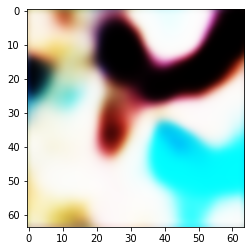

[0.2636214]
Progress: 11.81 %     Dloss: 22.649459838867188    Sample time: 5.674s    _

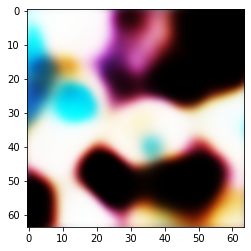

[0.49226165]
Progress: 12.13 %     Dloss: 24.02780532836914    Sample time: 5.682s    __

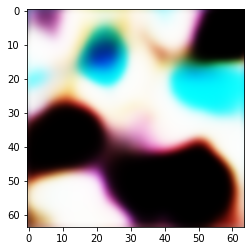

[0.4347207]
Progress: 12.45 %     Dloss: 22.949691772460938    Sample time: 5.710s    _

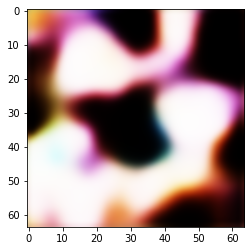

[0.37015337]
Progress: 12.77 %     Dloss: 22.890621185302734    Sample time: 5.684s    _

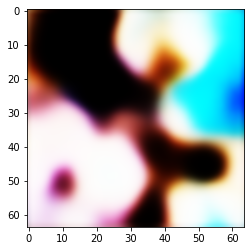

[0.27875444]
Progress: 13.09 %     Dloss: 22.809066772460938    Sample time: 5.675s    _

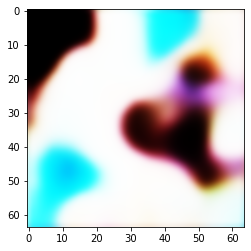

[0.6146256]
Progress: 13.41 %     Dloss: 23.988941192626953    Sample time: 5.633s    _

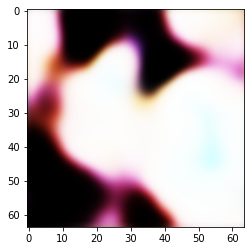

[0.48926905]
Progress: 13.73 %     Dloss: 23.302230834960938    Sample time: 5.675s    _

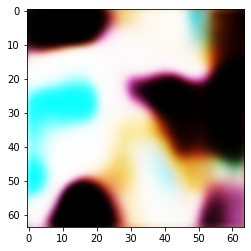

[0.48118976]
Progress: 14.05 %     Dloss: 22.75095558166504    Sample time: 5.680s    __

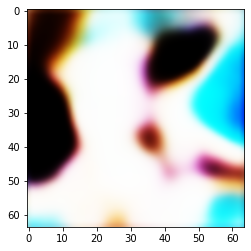

[0.5110852]
Progress: 14.37 %     Dloss: 22.739173889160156    Sample time: 5.653s    _

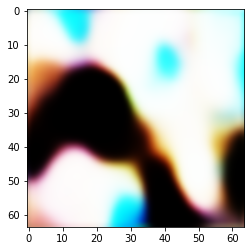

[0.58506495]
Progress: 14.69 %     Dloss: 23.277599334716797    Sample time: 5.699s    _

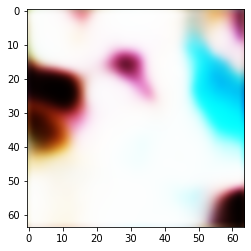

[0.6064863]
Progress: 15.01 %     Dloss: 23.367128372192383    Sample time: 5.714s    _

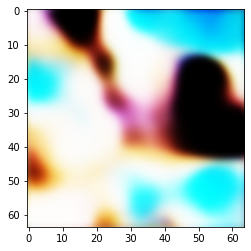

[0.09306996]
Progress: 15.33 %     Dloss: 22.884843826293945    Sample time: 5.649s    _

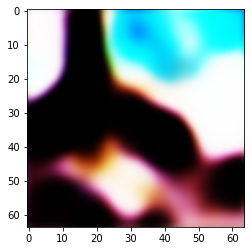

[0.5898992]
Progress: 15.65 %     Dloss: 22.61205291748047    Sample time: 5.667s    __

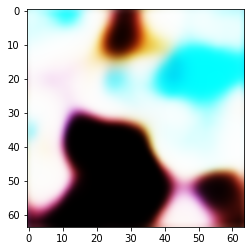

[0.35006976]
Progress: 15.97 %     Dloss: 23.943660736083984    Sample time: 5.683s    _

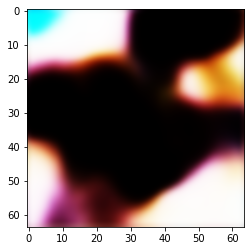

[0.689616]
Progress: 16.29 %     Dloss: 23.657684326171875    Sample time: 5.710s    _

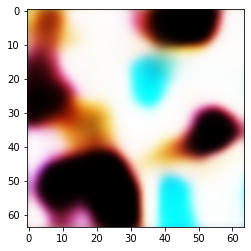

[0.53842646]
Progress: 16.45 %     Dloss: 22.899961471557617    Sample time: 8.180s    _

KeyboardInterrupt: 

In [41]:
epochs=10
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

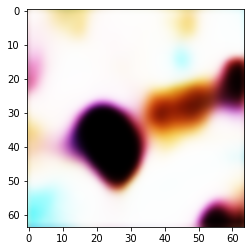

[0.5150735]


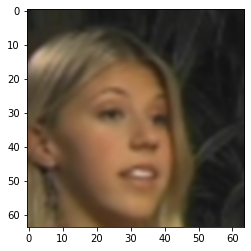

[[0.5065415]]


In [42]:
noise=np.random.randn(32,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=get_batch(np.random.randint(low=0,high=len(names)),1)
plt.imshow((img[0]+1)/2,interpolation='bicubic')
plt.show()
print(d.predict(img))

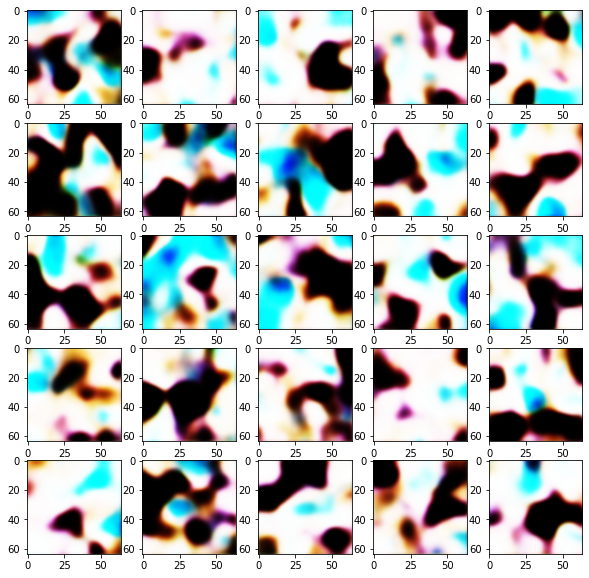

In [43]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow((gen[i].squeeze()+1)/2,interpolation='bicubic')